In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
import numpy as np

from datetime import datetime, timedelta
from matplotlib.ticker import MultipleLocator
from sunpy.coordinates import HeliographicCarrington, HeliocentricEarthEcliptic, get_body_heliographic_stonyhurst, get_horizons_coord
from sunpy.time import parse_time
from astropy.coordinates import Longitude, SkyCoord

# This script is based on a sunpy example:
# https://docs.sunpy.org/en/stable/generated/gallery/showcase/where_is_stereo.html

# initialize the body dictionary
body_dict = dict.fromkeys(['Mercury', 199], [199, 'Mercury', 'darkturquoise'])
body_dict.update(dict.fromkeys(['Venus', 299], [299, 'Venus', 'darkorchid']))
body_dict.update(dict.fromkeys(['Earth', 'EARTH', 'earth', 399], [399, 'Earth', 'green']))
body_dict.update(dict.fromkeys(['Mars', 499], [499, 'Mars', 'maroon']))
body_dict.update(dict.fromkeys(['Jupiter', 599], [599, 'Jupiter', 'navy']))
body_dict.update(dict.fromkeys(['L1', 31], [31, 'SEMB-L1', 'black']))
body_dict.update(dict.fromkeys(['ACE', 'Advanced Composition Explorer', -92], [-92, 'ACE', 'dimgrey']))
body_dict.update(dict.fromkeys(['STEREO B', 'STEREO-B', 'STB', 'stb', -235], [-235, 'STEREO B', 'b']))
body_dict.update(dict.fromkeys(['STEREO A', 'STEREO-A', 'STA', 'sta', -234], [-234, 'STEREO A', 'red']))
body_dict.update(dict.fromkeys(['SOHO', 'soho', -21], [-21, 'SOHO', 'darkgreen']))
body_dict.update(dict.fromkeys(['Solar Orbiter', 'SolO', 'solarorbiter', 'SolarOrbiter', -144], [-144, 'Solar Orbiter', 'dodgerblue']))
body_dict.update(dict.fromkeys(['PSP', 'Parker Solar Probe', 'parkersolarprobe', 'ParkerSolarProbe', -96], [-96, 'Parker Solar Probe', 'purple']))
body_dict.update(dict.fromkeys(['BepiColombo', 'Bepi Colombo', 'Bepi', 'MPO', -121], [-121, 'BepiColombo', 'orange']))

def spiral(pos, sw_speed, date):
    omega = 360. * u.degree / (25.38 * 24 * 60 * 60 * u.second)  # rot-angle in rad/sec, sidereal period
    r = np.arange(1, pos.radius.to_value(u.R_sun), 0.1) * u.R_sun
    alpha = omega * ((pos.radius - r) / sw_speed)
    hg_coord = SkyCoord(pos.lon+alpha, pos.lat, r,
                        frame=pos.frame)
    return hg_coord

def orbit_plot(time, fig, ax):

    ##############################################################################
    # Define the time for the plot as the time when this script is run.

    obstime = parse_time(time)

    ##############################################################################
    # Define a convenience function to extract the first full orbit from a
    # trajectory, assuming that the trajectory moves in the direction of positive
    # ecliptic longitude.

    hee_frame = HeliocentricEarthEcliptic(obstime=obstime)

    def get_first_orbit(coord):
        lon = coord.transform_to(hee_frame).spherical.lon
        shifted = Longitude(lon - lon[0])
        ends = np.flatnonzero(np.diff(shifted) < 0)
        if ends.size > 0:
            return coord[:ends[0]]
        return coord

    ##############################################################################
    # Obtain the locations and trajectories of the various planets and spacecraft.
    # To ensure that each trajectory contains at least one full orbit, we request
    # 700 days for each planet and 1 year for each spacecraft.

    planets = ['Mercury', 'Venus', 'Earth']
    times = obstime + np.arange(700) * u.day
    planet_coords = {planet: get_first_orbit(get_body_heliographic_stonyhurst(planet, times))
                    for planet in planets}

    stereo_a = get_horizons_coord('STEREO-A', obstime)
    stereo_b = get_horizons_coord('STEREO-B', obstime)

    missions = ['Parker Solar Probe', 'Solar Orbiter', 'BepiColombo'] # , 'BepiColombo'
    mission_labels = {'Parker Solar Probe': 'PSP', 'Solar Orbiter': 'SolO', 'BepiColombo': 'Bepi'}
    mission_colors = {'Parker Solar Probe': 'purple', 'Solar Orbiter': 'dodgerblue', 'BepiColombo': 'orange'}
    mission_coords = {mission: get_first_orbit(get_horizons_coord(mission, {'start': obstime,
                                                                            'stop': obstime + 1 * u.yr,
                                                                            'step': '6h'}))
                    for mission in missions}

    ##############################################################################
    # Define a convenience function for converting coordinates to plot positions
    # in the ecliptic plane.

    def coord_to_heexy(coord):
        coord = coord.transform_to(hee_frame)
        coord.representation_type = 'cartesian'
        return coord.y.to_value('AU'), coord.x.to_value('AU')

    ##############################################################################
    # Set Matplotlib settings to the desired appearance and initialize the axes.
    ax.set_xlim(-1.15, 1.15)
    ax.set_xlabel('Y (HEE)')
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    ax.set_ylim(1.15, -1.15)
    ax.set_ylabel('X (HEE)')
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))

    ax.set_title(f'Orbit Plot: {obstime.strftime("%d-%b-%Y %H:%M UT")}')
    ax.set_aspect('equal')

    # sphinx_gallery_defer_figures

    ##############################################################################
    # Draw the Sun-Earth line.

    ax.plot([0, 0], [0, 2], linestyle='dotted', linewidth=1, color='gray')

    # sphinx_gallery_defer_figures

    ##############################################################################
    # Draw Mercury, Venus, Earth, and Mars, with Earth formatted differently.

    for planet, coord in planet_coords.items():
        ax.plot(*coord_to_heexy(coord), linestyle='dashed', linewidth=1, color='gray')
        if planet == 'Earth':
            color, markersize, offset = 'green', None, 0.05
        elif planet == 'Venus':
            color, markersize, offset = 'gray', None, -0.25
        else:
            color, markersize, offset = 'gray', None, 0.05

        x, y = coord_to_heexy(coord[0])
        ax.plot(x, y, 'o', markersize=markersize, color=color)
        ax.text(x + offset, y, planet, color=color, clip_on=True)

        if planet == 'Earth':
            spiral_coord = spiral(SkyCoord(coord[0]), 350*(u.km/u.second), obstime)
            ax.plot(*coord_to_heexy(spiral_coord), linestyle='-', linewidth=1, color=color)

    # sphinx_gallery_defer_figures

    ##############################################################################
    # Draw the STEREO spacecraft (without orbits), as well as Sun-STEREO lines.

    for stereo, label, color in [(stereo_a, 'STA', 'red'), ]: # , (stereo_b, 'B', 'blue')
        x, y = coord_to_heexy(stereo)
        ax.plot([0, 5*x], [0, 5*y], linestyle='dotted', linewidth=1, color='gray')
        ax.plot(x, y, 'o', color=color)
        ax.text(x + 0.05, y, label, color=color, fontsize=12, clip_on=True)

        spiral_coord = spiral(stereo, 350*(u.km/u.second), obstime)
        ax.plot(*coord_to_heexy(spiral_coord), linestyle='-', linewidth=1, color=color)

    # sphinx_gallery_defer_figures

    ##############################################################################
    # Draw the Sun, which is at the origin by definition.

    ax.plot(0, 0, 'o', markersize=5, color='orange', zorder=100)
    # ax.text(0.09, 0, 'Sun', color='orange')

    # sphinx_gallery_defer_figures

    ##############################################################################
    # Finally, draw the various spacecraft, with Solar Orbiter colored differently.

    for mission, coord in mission_coords.items():
        ax.plot(*coord_to_heexy(coord), linestyle='dashed', color=mission_colors[mission])
        
        x, y = coord_to_heexy(coord[0])
        ax.plot(x, y, 'o', color=mission_colors[mission])
        print(coord[0])
        spiral_coord = spiral(coord[0], 350*(u.km/u.second), obstime)
        ax.plot(*coord_to_heexy(spiral_coord), linestyle='-', linewidth=1.5, color=mission_colors[mission])

        ax.text(x + 0.05, y, mission_labels[mission], color=mission_colors[mission], clip_on=True)
    
    obstime_plus = parse_time(time+timedelta(days=1))
    mission_coords_plus = {mission: 
        get_first_orbit( 
                        get_horizons_coord(mission,
                            {'start': obstime_plus,
                            'stop': obstime_plus + 0.5 * u.yr,
                            'step': '6h'}
                            )
                        ) 
        for mission in missions}
    
    for mission, coord in mission_coords_plus.items():
       if mission=='Parker Solar Probe':
           x, y = coord_to_heexy(coord[0])
           ax.plot(x, y, '*', color=mission_colors[mission], markersize=8)
           ax.text(x - 0.15, y-0.025, '+1day', color=mission_colors[mission], fontsize=6)

    CME = SkyCoord([295*u.deg, 295*u.deg], [-40*u.deg, 40*u.deg], [0*u.AU, 1*u.AU], frame=HeliographicCarrington(obstime=obstime, observer='Earth'))
    x, y = coord_to_heexy(CME)
    arrow_properties = dict(facecolor='black', edgecolor='black', arrowstyle='->', shrinkA=0, linewidth=1)
    ax.annotate('', xy=(x[-1], y[-1]), xytext=(x[-2], y[-2]), arrowprops=arrow_properties)
    ax.text(x[1] - 0.01, y[1], 'CME', color='black', clip_on=True)


    return fig, ax


# Plot the Spacecraft Orbit in 2D

The code bellow will produce a plot with the spacecraft orbits in 2D

INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for STEREO-B (spacecraft) (-235) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for BepiColombo (Spacecraft) (-121) [sunpy.coordinates.ephemeris]
<SkyCoord (HeliographicStonyhurst: obstime=2022-09-05T16:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (116.77268559, -1.58933121, 0.07187497)>
<SkyCoord (HeliographicStonyhurst: obstime=2022-09-05T16:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (149.38129858, -3.42412116, 0.70267244)>
<SkyCoord (HeliographicStonyhurst: obstime=2022-09-05T16:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (-99.68795747, -3.318166

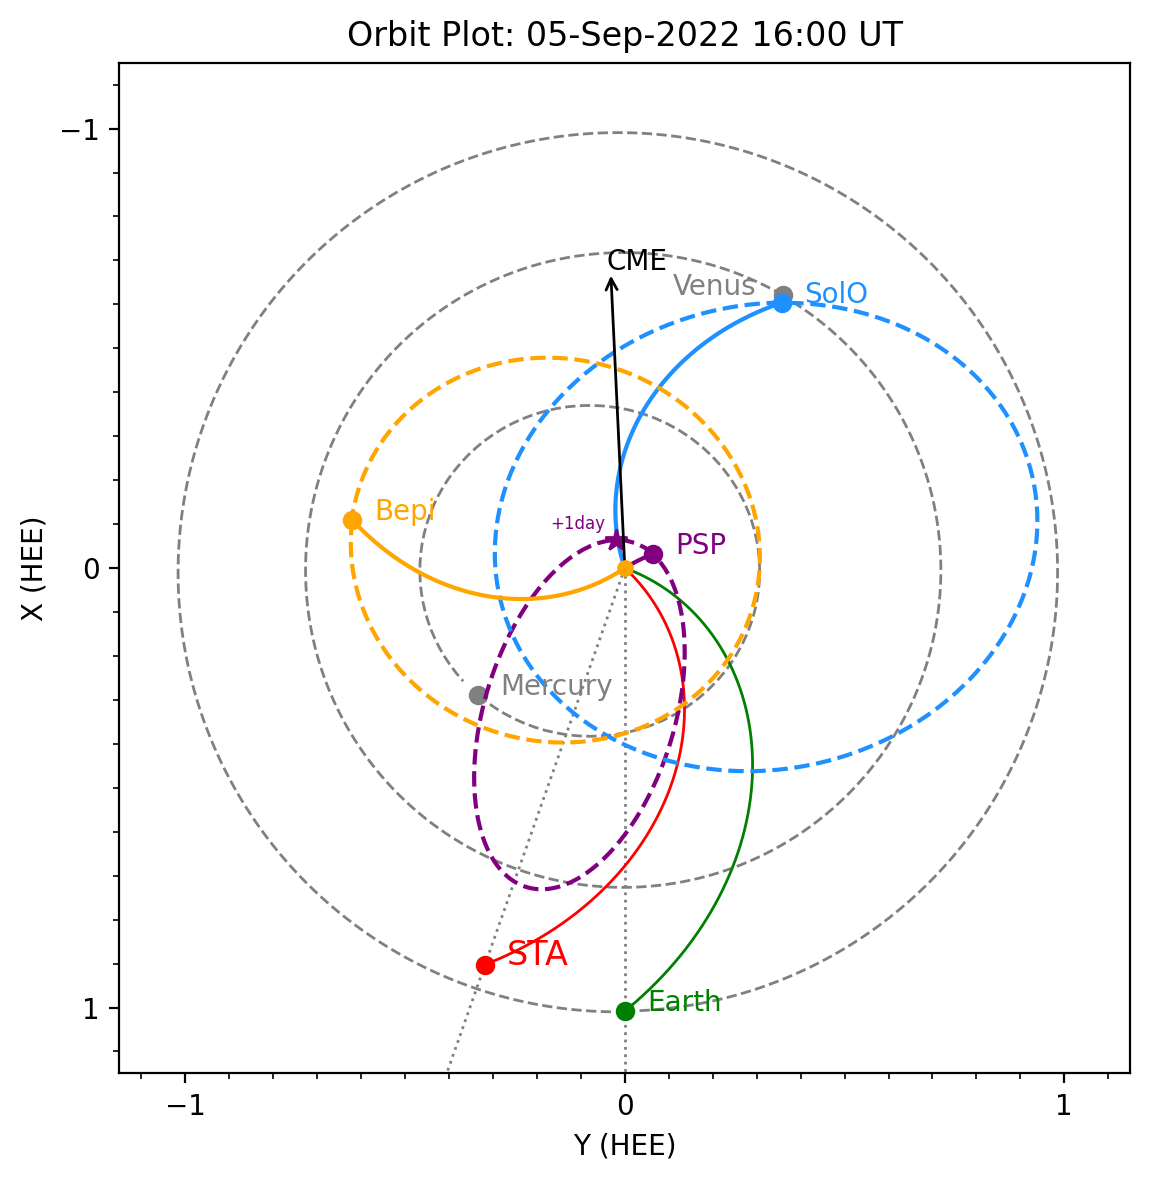

In [2]:
import datetime

current_date = datetime.datetime(2022, 9, 5, 16, 0, 0)

fig, axs = plt.subplots(figsize=(6, 6), dpi=200)
fig, axs = orbit_plot(current_date, fig=fig, ax=axs)
fig.tight_layout()
# fig.savefig(f'./Orbit_plots/{current_date.strftime("%Y%m%d%H%M")}', dpi=200, bbox_inches='tight')

plt.show()